# Introduction

I used 20 years of data on Kobe's made and missed shots from the Kobe Bryant Shot Selection Kaggle Competition to predict whether he made a shot or not. I used the data from the competition, feature engineered a couple variables, as well as used different machine learning methods for this classification problem. I also had the help from classmates and some of the publicly available notebooks. The three machine learning techniques I used were a naive bayes, a random forest, and a KNN model. Ultimately, the random forest performed best. Running it on my machine and then submitting the file, I received a score of 0.59955 . That script is now in this notebook, and the best score I got was 0.59968 . 

# Libraries and Data

In order to begin, I loaded the following packages:

In [1]:
library(tidyverse)
library(vroom)
library(forecast)
library(patchwork)
library(embed)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘vroom’


The following objects are masked from ‘package:readr’:

    as.col_spec, col_character, col_date, col_datetime, col_double,
    col_factor, col_guess, col_integer, col_logical, col_number,
    col_skip, col_time, cols, cols_condense, cols_only, date_names,
    date_names_lang, date_names_langs, default_locale, fwf_cols,
    fwf_empty, fwf_positions, fwf_widths, locale, output_column,
    problems, spec


Registered S3 method overwritten by 'q

Once the packages were loaded, I imported the data. I called the data, "kobe".

In [2]:
kobe <- vroom("/kaggle/input/kobe-bryant-shot-selection/data.csv.zip")

Rows: 30697 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): action_type, combined_shot_type, season, shot_type, shot_zone_are...
dbl  (14): game_event_id, game_id, lat, loc_x, loc_y, lon, minutes_remaining...
date  (1): game_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Exploratory Data Analysis

Now that I had the data, I needed to figure out what variables to use (or build) for the training set.

To begin, I looked at the *lon*, *lat*, *loc_x*, and *loc_y* variables. Creating scatterplots with these variables depicted shot maps of where Kobe's shots were taken on on each end of the basketball court over his career.

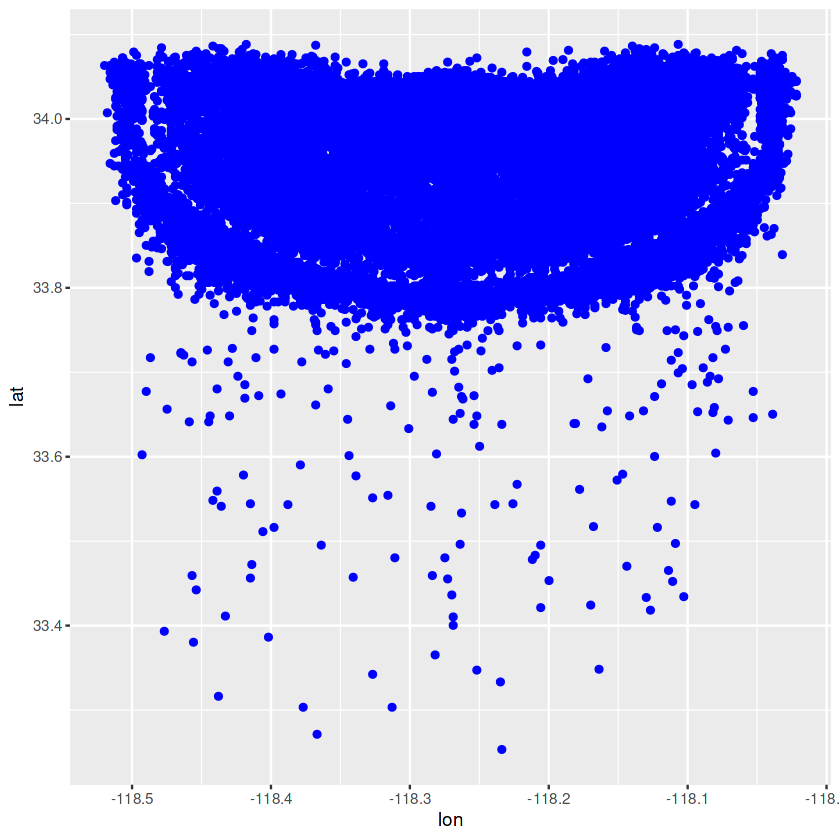

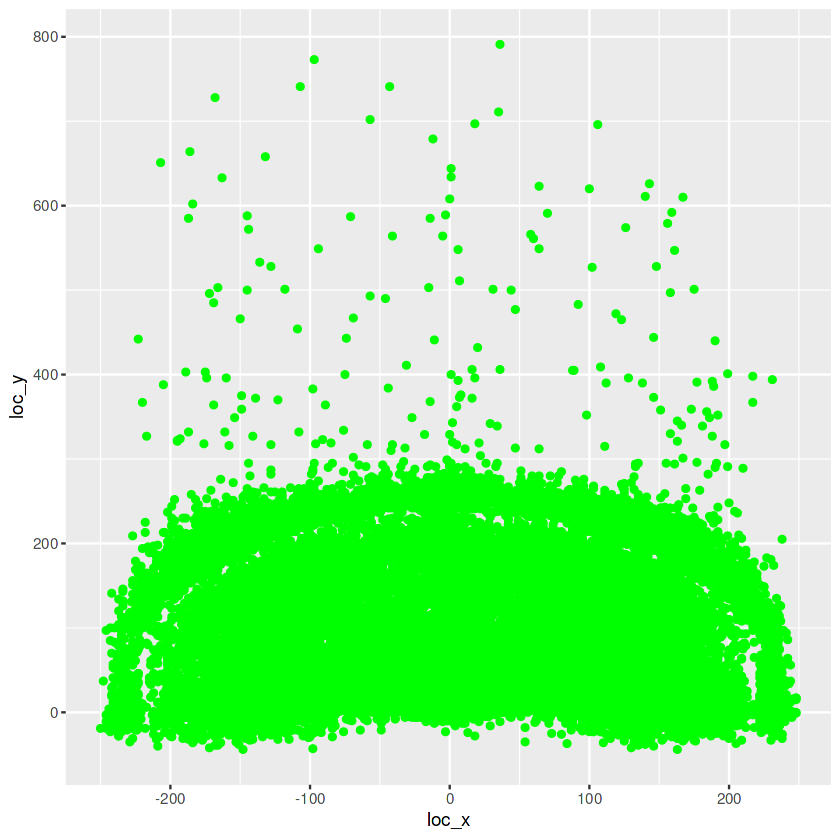

In [3]:
ggplot(data = kobe) +
geom_point(mapping = aes(x = lon, y = lat), color = 'blue')

ggplot(data = kobe) +
  geom_point(mapping = aes(x = loc_x, y = loc_y), color = 'green')

With the plots above, I had ideas on how to use *lon*, *lat*, *loc_x*, and *loc_y* variables. These are fleshed out in the feature engineering section.

# Feature Engineering

The shot map plots above depicts semi-circles on each end of the basketball court. So instead of using cartesian coordinates, I used polar coordinates. In order to do this, I took *loc_x* and *loc_y* variables (which represent Kobe's floor location in cartesian coordinates) and created the variables *dist* and *angle* which represents Kobe's floor location in polar coordinates.

In [4]:
## Converting it to polar coordinates

dist <- sqrt((kobe$loc_x/10)^2 + (kobe$loc_y/10)^2)
kobe$shot_distance <- dist

#Creating angle column
loc_x_zero <- kobe$loc_x == 0
kobe['angle'] <- rep(0,nrow(kobe))
kobe$angle[!loc_x_zero] <- atan(kobe$loc_y[!loc_x_zero] / kobe$loc_x[!loc_x_zero])
kobe$angle[loc_x_zero] <- pi / 2

I then combined the *minutes_remaining* and *seconds_remaining* variables into a single *time_remaining* variable which represents the total time remaining in a quarter in seconds.

In [5]:
# Create one time variable
kobe$time_remaining = (kobe$minutes_remaining*60)+kobe$seconds_remaining

The *matchup* variable was changed to record whether games were 'Home' or 'Away' based on the presence of the substring 'vs.' in the existing *matchup* variable.

In [6]:
# Home and Away
kobe$matchup = ifelse(str_detect(kobe$matchup, 'vs.'), 'Home', 'Away')

Another variable I made was the *season* variable. It extracts the second digit of the second part of a season range and assigns it to a new variable called *season*.

In [7]:
# Season
kobe['season'] <- substr(str_split_fixed(kobe$season, '-',2)[,2],2,2)

This converts the values in the existing *game_date* variable to numeric format. 

In [8]:
# Game number
kobe$game_num <- as.numeric(kobe$game_date)

Another variable I made was *postachilles*. It is determined based on whether the values in the *game_num* variable are greater than 1452. If it is greater than 1452, the value in *postachilles* is set to 1; otherwise, it is set to 0. It indicates whether the game occurred before or after Kobe Bryant's Achilles injury.

In [9]:
# Achilles injury before and after
kobe$postachilles <- ifelse(kobe$game_num > 1452, 1, 0)

I also included the variable *mvp* in the data set. It is determined based on whether the values in the *game_num* variable fall within the range from 909 to 990. If it is within this range, the corresponding value in *mvp* is set to 1; otherwise, it is set to 0. It indicates whether the game occurred during a period associated with Kobe Bryant's MVP status.

In [10]:
# MVP
kobe$mvp <- ifelse(kobe$game_num >= 909 & kobe$game_num <= 990, 1, 0)

I converted the *period* variable in the data set into a factor.

In [11]:
# period into a factor
kobe$period <- as.factor(kobe$period)

I then created a filtered data frame called "kobe_f" by subsetting the original data frame. I am only keeping the variables that will end up being passed to the model.

In [12]:
kobe_f <- kobe %>%
  select(-c('shot_id', 'team_id', 'team_name', 'shot_zone_range', 'lon', 'lat',
            'seconds_remaining', 'minutes_remaining', 'game_event_id',
            'game_id', 'game_date','shot_zone_area',
            'shot_zone_basic', 'loc_x', 'loc_y'))

# Training and Testing Data

Once I had all the variables that will be used in the model, I needed a training data set and testing data set. In order to do that, the data was split on the *shot_made_flag* variable. If it is a 0 or 1, it will go into the training data. Anything else (NA) will go into the testing data.

This is the code used for the training data. If the *shot_made_flag* is not a missing value, it is put into the training data.

In [13]:
# Train
train <- kobe_f %>%
  filter(!is.na(shot_made_flag))

This is the code used for the testing data. If the *shot_made_flag* is a missing value, it is put into the testing data

In [14]:
# Test
test <- kobe_f %>%
  filter(is.na(shot_made_flag))

The *shot_made_flag* in the training data was converted into a factor.

In [15]:
# Make the response variable into a factor
train$shot_made_flag <- as.factor(train$shot_made_flag)

This is the recipe I will be using for the machine learning model. It handles novel and uknown levels in nominal predictors and converts them into dummy variables for use in modeling. It is so the model can handle new or unknown categorical levels during testing.

In [16]:
recipe <- recipe(shot_made_flag ~ ., data = train) %>%
  step_novel(all_nominal_predictors()) %>%
  step_unknown(all_nominal_predictors()) %>%
  step_dummy(all_nominal_predictors())

The *test.id* variable contains the *shot_id* values corresponding to the rows in the data set where the *shot_made_flag* values are missing. This is for the submission file.

In [17]:
test.id <- kobe %>% filter(is.na(shot_made_flag)) %>% select(shot_id)

# Random Forest

Now I can build the random forest model and tune it. The code chunk below prepares and registers a parallel cluster, enabling parallel processing in R. It is useful for speeding up computations.

In [18]:
library(doParallel)

num_cores <- parallel::detectCores()

cl <- makePSOCKcluster(num_cores)

registerDoParallel(cl)

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel



This code specifies a random forest model with hyperparameters to be tuned and a fixed number of trees. The model engine is set to "ranger" and the mode is set to "classification". Then a workflow object is created. It establishes a workflow for a classification task using a random forest model with hyperparameter tuning. It uses the recipe defined above and the workflow can be used for training and evaluating the model.

In [19]:
## Create a workflow with model & recipe

my_mod_kf <- rand_forest(mtry = tune(),
                         min_n=tune(),
                         trees=800) %>%
  set_engine("ranger") %>%
  set_mode("classification")


kobe_workflow <- workflow() %>%
  add_recipe(recipe) %>%
  add_model(my_mod_kf)

This code creates a grid of tuning values for hyperparameter tuning with three levels for the "mtry" and "min_n" parameters. The specific values within the ranges are determined by the "grid_regular" function. This grid is used for tuning the random forest model in the workflow.

In [20]:
## Set up grid of tuning values

tuning_grid <- grid_regular(mtry(range = c(1,(ncol(train)-1))),
                            min_n(),
                            levels = 3)

The code chunk below creates a cross-validation plan with 3-fold cross-validation and one repeat. This plan is used to train and evaluate the model in the specified workflow using cross-validation.

In [21]:
## Set up K-fold CV

folds <- vfold_cv(train, v = 3, repeats=1)

This code performs hyperparameter tuning for the random forest model using cross-validation results. The "tune_grid" function tunes the hyperparameters of the model using the specified grid of tuning values and evaluates performance on cross-validated data. The performance metric used is ROC AUC. I then select the best set of hyperparameters based on the ROC AUC metric from the tuning results. The resulting object contains the optimal hyperparameters for the random forest model based on the cross-validated performance. These hyperparameters can be used to train the final model on the entire training dataset.

In [22]:
## Find best tuning parameters

CV_results <- kobe_workflow %>%
  tune_grid(resamples=folds,
            grid=tuning_grid,
            metrics=metric_set(roc_auc))

best_tune_rf <- CV_results %>%
  select_best("roc_auc")

The code chunk below finalizes the machine learning workflow and generates predictions on the testing data. The "finalize_workflow" function takes the best-tuned hyperparameters and finalizes the workflow, incorporating the optimal settings. The finalized workflow is fit to the training data, training the model with the optimal hyperparameters. Then, the "predict" function generates predictions on the testing data using the trained model. I want probability scores rather than class labels, so that is why I specified "prob" in the "type" function. The results are the predicted probabilities for each observation in the test set. This is what we will submit to assess the model's confidence in its predictions.

In [23]:
## Finalize workflow and predict

final_wf <- kobe_workflow %>%
  finalize_workflow(best_tune_rf) %>%
  fit(data=train)

kobe_predictions_rf <- final_wf %>% predict(new_data=test,
                                            type="prob")

This last code chunk prepares the final submission file for the competition. I used the *test.id* variable and combined it with the predicted probabilities generated by the random forest model. I then renamed the column names, wrote the CSV file to submit for evaluation, and stopped the parallel cluster.

In [24]:
kobe_rf_submit <- as.data.frame(cbind(test.id, as.character(kobe_predictions_rf$.pred_1)))

colnames(kobe_rf_submit) <- c("shot_id", "shot_made_flag")

write_csv(kobe_rf_submit, "kobe_rf_submit.csv")

stopCluster(cl)

# Conclusion

The random forest was the best model I created. The best score I got running the script in the notebook was 0.59968 . At the time of this published notebook, it would be in 35th place. The score I got on my personal device of 0.59955 would be 30th place. This was a fun challenge to learn more about machine learning techniques, feature engineering, and cloud computing.